<a href="https://colab.research.google.com/github/meti-94/TextClassification/blob/main/BTC_historical_data_plus_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
## install finrl library
!pip install OpenBlender -q
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git -q

     |████████████████████████████████| 234 kB 22.9 MB/s 
     |████████████████████████████████| 176 kB 47.1 MB/s 
     |████████████████████████████████| 59.6 MB 1.3 MB/s 
     |████████████████████████████████| 1.8 MB 30.4 MB/s 
     |████████████████████████████████| 124 kB 56.5 MB/s 
     |████████████████████████████████| 147 kB 46.7 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 2.4 MB 42.5 MB/s 
     |████████████████████████████████| 153 kB 49.4 MB/s 
     |████████████████████████████████| 195 kB 50.5 MB/s 
     |████████████████████████████████| 90.8 MB 337 bytes/s 
     |████████████████████████████████| 448 kB 51.7 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 3.6 MB 45.3 MB/s 
     |████████████████████████████████| 1.1 MB 42.6 MB/s 
     |████████████████████████████████| 271 kB 50.2 MB/s 
     |████████████████████████████████| 94 kB 483 kB/s 
     |███████████

In [3]:
from finrl.apps import config
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
from datetime import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [8]:
def read_data(path):
    hist = pd.read_csv(path, parse_dates=True)
    hist = hist[hist.Timestamp>=1388521800]
    hist['date'] = hist['Timestamp'].apply(lambda item:datetime.fromtimestamp(item))
    hist.set_index('date', inplace=True)
    hist.dropna(inplace=True)
    return hist

def resampling(hist, timeframe='1min'):
    ohlc = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume_(BTC)':'sum',
        'Timestamp':'last'
    }
    df = hist.resample(timeframe, origin='end_day').apply(ohlc)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'Open':'open', 'High':'high', 'Close':'close', 'Low':'low', 'Volume_(BTC)':'volume'}, inplace=True)
    df['date'] = df['date'].astype(str)
    df['tic'] = ['BTC' for _ in range(len(df))]
    df['day'] = [i%5 for i in range(len(df))]
    return df   
hist = read_data('/content/drive/MyDrive/kaggle_dataset/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
hist = hist['2014-01-01' :'2021-03-30']
hist = resampling(hist, timeframe='D')


In [9]:
hist.head()

,date,open,high,low,close,volume,Timestamp,tic,day
0,2014-01-01,732.00,732.00,732.00,732.00,4.599562,1.388534e+09,BTC,0
1,2014-01-02,732.01,757.99,729.01,754.90,7903.038301,1.388621e+09,BTC,1
2,2014-01-03,751.88,798.70,742.50,784.19,15134.172831,1.388707e+09,BTC,2
3,2014-01-04,784.12,818.99,767.62,809.40,14860.259005,1.388794e+09,BTC,3
4,2014-01-05,808.24,830.00,790.20,828.83,11004.642948,1.388880e+09,BTC,4


In [14]:
import OpenBlender
search_keyword = 'bitcoin'
token = '6202196495162976a11f13427bR0IFUfKQpLS3avztPiBSshLluOg1'
df = df.sort_values('Timestamp').reset_index(drop = True)
print('From : ' + OpenBlender.unixToDate(min(df.Timestamp)))
print('Until: ' + OpenBlender.unixToDate(max(df.Timestamp)))
OpenBlender.searchTimeBlends(token,
                             df.Timestamp,
                             search_keyword)
 

From : 01-01-2014 00:00:00
Until: 30-03-2021 23:59:00


[{'description': 'Daily prices and volumes for the digital currency BitcoinsCash.',
  'features': ['close',
   'high',
   'low',
   'market_cap',
   'open',
   'timestamp',
   'volume'],
  'id_dataset': '5d9f899b951629329a748593',
  'intersection': 50.888120141544924,
  'name': 'Bitcoins Cash Historical data',
  'num_observations': 1671,
  'url': 'https://www.openblender.io/#/dataset/explore/5d9f899b951629329a748593'},
 {'description': '',
  'features': ['date',
   'feargreed_index',
   'feargreed_classification',
   'bitcoin_search',
   'coinbase_search',
   'crypto_search',
   'ethereum_search'],
  'id_dataset': '6114e0ed9516295907e7f5d4',
  'intersection': 43.61298595704889,
  'name': 'BTC Fear&Greed   Google Analyst weekly searches',
  'num_observations': 1288,
  'url': 'https://www.openblender.io/#/dataset/explore/6114e0ed9516295907e7f5d4'},
 {'description': '',
  'features': ['settimana', 'bitcoin', 'coinbase', 'crypto', 'ethereum'],
  'id_dataset': '6114d7009516295906ef5474',
  

In [30]:
token = '6202196495162976a11f13427bR0IFUfKQpLS3avztPiBSshLluOg1'
blend_source = {
                'id_dataset':'5ea2039095162936337156c9',
                'feature' : 'text'
            }
df_blend = OpenBlender.timeBlend( token = token,
                                  anchor_ts = hist.Timestamp,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals',
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior',
                                  interval_output = 'list',
                                  missing_values = 'raw')
df = pd.concat([hist, df_blend.loc[:, df_blend.columns != 'timestamp']], axis = 1)
df.head()

Task ID: '620261f80895fafb4a9d8d4c'.
Total estimated consumption: 9260.8 processing units.
Task confirmed. Starting download..
38.0%
76.0%
100%


,date,open,high,low,close,volume,Timestamp,tic,day,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days
0,2014-01-01,732.00,732.00,732.00,732.00,4.599562,1.388534e+09,BTC,0,0,[]
1,2014-01-02,732.01,757.99,729.01,754.90,7903.038301,1.388621e+09,BTC,1,0,[]
2,2014-01-03,751.88,798.70,742.50,784.19,15134.172831,1.388707e+09,BTC,2,0,[]
3,2014-01-04,784.12,818.99,767.62,809.40,14860.259005,1.388794e+09,BTC,3,0,[]
4,2014-01-05,808.24,830.00,790.20,828.83,11004.642948,1.388880e+09,BTC,4,0,[]


In [31]:
token = '6202196495162976a11f13427bR0IFUfKQpLS3avztPiBSshLluOg1'
positive_filter = {'name' : 'positive', 
                   'match_ngrams': ['positive', 'buy', 
                                    'bull', 'boost']}
blend_source = {
                'id_dataset':'5ea2039095162936337156c9',
                'feature' : 'text',
                'filter_text' : positive_filter
               }
df_blend = OpenBlender.timeBlend( token = token,
                                  anchor_ts = df.Timestamp,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals',
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior',
                                  interval_output = 'list',
                                  missing_values = 'raw')
df = pd.concat([df, df_blend.loc[:, df_blend.columns != 'timestamp']], axis = 1)
# And now the negatives
negative_filter = {'name' : 'negative', 
                   'match_ngrams': ['negative', 'loss', 'drop', 'plummet', 'sell', 'fundraising']}
blend_source = {
                'id_dataset':'5ea2039095162936337156c9',
                'feature' : 'text',
                'filter_text' : negative_filter
               }
df_blend = OpenBlender.timeBlend( token = token,
                                  anchor_ts = df.Timestamp,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals', #closest_observation
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior',
                                  interval_output = 'list',
                                  missing_values = 'raw')

df = pd.concat([df, df_blend.loc[:, df_blend.columns != 'timestamp']], axis = 1)

Task ID: '620262180895fafb4a9d8d4c'.
Total estimated consumption: 9260.8 processing units.
Task confirmed. Starting download..
38.0%
76.0%
100%
Task ID: '620262260895fafb4a9d8d4c'.
Total estimated consumption: 9260.8 processing units.
Task confirmed. Starting download..
38.0%
76.0%
100%


In [36]:
# df.drop(columns=['Timestamp', 'BITCOIN_NE.text_last1days', 'BITCOIN_NE.text_last1days:positive', 'BITCOIN_NE.text_last1days:negative'], inplace=True)
df.rename(columns={'BITCOIN_NE.text_COUNT_last1days:positive':'pos', 'BITCOIN_NE.text_COUNT_last1days':'all', 'BITCOIN_NE.text_COUNT_last1days:negative':'neg'}, inplace=True)
df.tail()

,date,open,high,low,close,volume,tic,day,all,pos,neg
2639,2021-03-27,51372.34,55300.00,51372.34,55261.73,4881.915299,BTC,4,23,1,2
2640,2021-03-28,55295.63,56686.15,53948.35,55920.82,2601.956453,BTC,0,16,0,0
2641,2021-03-29,55946.79,56573.04,54677.51,55804.36,2074.410637,BTC,1,14,1,1
2642,2021-03-30,55822.98,58402.68,54892.42,57670.58,5363.655852,BTC,2,19,0,0
2643,2021-03-31,57582.17,59388.66,57011.00,58760.59,3387.376981,BTC,3,23,5,1


In [37]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1823, 8)
Successfully added vix
Successfully added turbulence index


In [38]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [39]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,all,pos,neg,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2014-01-02,BTC,732.01,757.99,729.01,754.90,7903.038301,1.0,0.0,0.0,0.0,0.513782,775.835491,711.064509,100.000000,66.666667,100.000000,743.450000,743.450000,14.23,0.0
1,2014-01-03,BTC,751.88,798.70,742.50,784.19,15134.172831,2.0,0.0,0.0,0.0,1.562941,809.350233,704.709767,100.000000,100.000000,100.000000,757.030000,757.030000,13.76,0.0
2,2014-01-06,BTC,828.83,948.00,826.07,905.00,24067.042492,0.0,0.0,0.0,0.0,8.400712,925.084076,679.689257,100.000000,156.587191,100.000000,802.386667,802.386667,13.55,0.0
3,2014-01-07,BTC,905.23,995.00,876.00,915.56,25901.389228,1.0,0.0,0.0,0.0,11.327710,959.495829,677.612742,100.000000,135.731314,100.000000,818.554286,818.554286,12.92,0.0
4,2014-01-08,BTC,915.56,943.00,780.00,780.00,34154.459703,2.0,0.0,0.0,0.0,6.661009,947.038964,680.431036,54.800819,23.683737,38.925707,813.735000,813.735000,12.87,0.0
5,2014-01-09,BTC,784.50,849.79,765.00,823.95,26210.364808,3.0,0.0,0.0,0.0,5.508577,939.750261,689.989739,60.750757,-3.530812,32.183687,814.870000,814.870000,12.89,0.0
6,2014-01-10,BTC,823.95,848.00,779.78,824.76,25299.469800,4.0,0.0,0.0,0.0,4.652651,933.763274,697.954726,60.849016,2.995430,32.183687,815.859000,815.859000,12.14,0.0
7,2014-01-13,BTC,894.70,905.00,826.46,841.52,12159.345801,2.0,0.0,0.0,0.0,7.168749,938.603016,714.432369,59.421119,49.184608,34.799890,826.517692,826.517692,13.28,0.0
8,2014-01-14,BTC,841.52,843.60,783.11,824.00,19363.714080,3.0,0.0,0.0,0.0,5.327803,934.034362,718.641353,56.898773,-13.546430,17.604009,826.337857,826.337857,12.28,0.0
9,2014-01-15,BTC,824.00,837.00,800.00,815.99,9730.124914,4.0,0.0,0.0,0.0,3.396149,929.564429,721.731571,55.778933,-12.171596,17.604009,825.648000,825.648000,12.28,0.0


In [40]:
processed_full.sort_values(['date','tic'],ignore_index=True).tail(10)

,date,tic,open,high,low,close,volume,day,all,pos,neg,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
1810,2021-03-17,BTC,55413.23,57150.00,53221.00,57127.98,7720.773149,4.0,22.0,0.0,1.0,3051.346731,61837.691982,42297.886018,61.113118,74.526036,14.449061,52161.940667,44871.618000,19.230000,0.207861
1811,2021-03-18,BTC,57079.16,59244.98,54124.00,59244.98,5854.798012,0.0,22.0,0.0,2.0,3129.511848,62643.039136,42720.536864,62.716614,97.604003,21.156922,52540.721000,45261.045167,21.580000,0.330618
1812,2021-03-19,BTC,59235.60,60083.25,57000.00,57524.96,5493.120625,1.0,22.0,0.0,1.0,3017.878798,62954.826429,43528.437571,60.615805,100.927726,23.715298,52816.865667,45621.242667,20.950001,0.748917
1813,2021-03-22,BTC,58038.65,58632.52,55500.00,57425.64,3627.440501,4.0,16.0,0.0,1.0,2680.504472,63206.317638,46523.724362,60.232799,66.745163,10.349283,53267.170333,46711.766833,18.879999,0.070404
1814,2021-03-23,BTC,57393.65,58461.78,53715.00,54262.78,6570.362893,0.0,16.0,0.0,0.0,2275.173323,62932.360532,47386.578468,56.349489,39.695376,2.396768,53210.667667,47105.283833,20.299999,2.076739
1815,2021-03-24,BTC,54249.05,55866.44,52933.03,54233.85,5001.192174,1.0,23.0,0.0,1.0,1929.370477,62791.824452,47932.868548,56.315135,23.444063,0.946121,53099.929667,47461.071500,21.200001,0.053881
1816,2021-03-25,BTC,54267.89,57207.33,51638.76,52349.40,6874.214748,2.0,25.0,3.0,2.0,1486.128697,62381.194383,48747.271617,54.092872,12.938777,4.753569,53039.933333,47800.005833,19.809999,0.991900
1817,2021-03-26,BTC,52291.72,53271.59,50360.00,51355.59,6668.912147,3.0,21.0,2.0,0.0,1042.645266,62072.803038,49301.593962,52.952880,-22.605052,0.947877,53119.601333,48118.446000,18.860001,0.401307
1818,2021-03-29,BTC,55946.79,56573.04,54677.51,55804.36,2074.410637,1.0,14.0,1.0,1.0,981.075478,61125.039038,51711.056962,57.113164,37.272459,12.953798,53915.662333,49316.047833,20.740000,3.051882
1819,2021-03-30,BTC,55822.98,58402.68,54892.42,57670.58,5363.655852,2.0,19.0,0.0,0.0,1104.926211,61240.759938,51861.956062,58.805280,58.878863,19.970756,54305.441667,49719.447000,19.610001,0.290028


In [41]:
train = data_split(processed_full, '2014-01-01','2019-12-30')
trade = data_split(processed_full, '2019-12-30','2021-03-30')
print(len(train))
print(len(trade))

1505
314


In [42]:
train.tail()

,date,tic,open,high,low,close,volume,day,all,pos,neg,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
1500,2019-12-20,BTC,7312.33,7372.12,7000.00,7152.85,5890.150193,1.0,0.0,0.0,0.0,-216.265923,7717.238116,6798.768884,43.565215,-47.098110,17.241634,7312.158000,8056.563333,12.51,0.325071
1501,2019-12-23,BTC,7136.01,7543.27,7124.52,7543.27,3835.810260,4.0,0.0,0.0,0.0,-139.578708,7691.133310,6783.759690,47.646910,55.852805,1.309110,7274.820000,8026.295500,12.61,1.264039
1502,2019-12-24,BTC,7543.27,7692.98,7247.86,7322.70,6665.968354,0.0,0.0,0.0,0.0,-120.652291,7693.103530,6784.140470,45.770106,59.041985,7.937096,7274.353333,8024.343000,12.67,0.527695
1503,2019-12-26,BTC,7255.55,7266.81,7110.73,7189.80,1505.818294,2.0,0.0,0.0,0.0,-105.458895,7681.627364,6783.439636,44.655744,-42.171316,1.135215,7288.348667,7965.316333,12.65,0.230259
1504,2019-12-27,BTC,7189.82,7432.00,7150.00,7187.00,3120.054271,3.0,0.0,0.0,0.0,-100.914876,7636.200714,6791.710286,44.631639,-14.549331,8.864639,7289.552333,7925.613000,13.43,0.007648


In [43]:
train.head()

,date,tic,open,high,low,close,volume,day,all,pos,neg,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2014-01-02,BTC,732.01,757.99,729.01,754.90,7903.038301,1.0,0.0,0.0,0.0,0.513782,775.835491,711.064509,100.000000,66.666667,100.000000,743.450000,743.450000,14.23,0.0
1,2014-01-03,BTC,751.88,798.70,742.50,784.19,15134.172831,2.0,0.0,0.0,0.0,1.562941,809.350233,704.709767,100.000000,100.000000,100.000000,757.030000,757.030000,13.76,0.0
2,2014-01-06,BTC,828.83,948.00,826.07,905.00,24067.042492,0.0,0.0,0.0,0.0,8.400712,925.084076,679.689257,100.000000,156.587191,100.000000,802.386667,802.386667,13.55,0.0
3,2014-01-07,BTC,905.23,995.00,876.00,915.56,25901.389228,1.0,0.0,0.0,0.0,11.327710,959.495829,677.612742,100.000000,135.731314,100.000000,818.554286,818.554286,12.92,0.0
4,2014-01-08,BTC,915.56,943.00,780.00,780.00,34154.459703,2.0,0.0,0.0,0.0,6.661009,947.038964,680.431036,54.800819,23.683737,38.925707,813.735000,813.735000,12.87,0.0


In [45]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + (len(config.TECHNICAL_INDICATORS_LIST)+3)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 14


In [48]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST+['all', 'pos', 'neg'], 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [49]:
env_train, _ = e_train_gym.get_sb_env()

In [50]:
agent = DRLAgent(env = env_train)

In [51]:

model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [52]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

------------------------------------
| time/                 |          |
|    fps                | 228      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.46    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.146   |
|    reward             | 0.0      |
|    std                | 1.04     |
|    value_loss         | 0.0108   |
------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 238        |
|    iterations         | 200        |
|    time_elapsed       | 4          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -1.49      |
|    explained_variance | 0.11       |
|    learning_rate      | 0.0007     |
|    n_updates    

In [53]:
data_risk_indicator = processed_full[(processed_full.date<'2019-12-30') & (processed_full.date>='2014-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [54]:
insample_risk_indicator.vix.describe()

count    1505.000000
mean       14.961708
std         4.045220
min         9.140000
25%        12.290000
50%        13.950000
75%        16.490000
max        40.740002
Name: vix, dtype: float64

In [55]:
insample_risk_indicator.vix.quantile(0.996)

30.408559844970696

In [56]:
insample_risk_indicator.turbulence.describe()

count    1505.000000
mean        0.928695
std         2.975403
min         0.000000
25%         0.003600
50%         0.095465
75%         0.568596
max        47.316742
Name: turbulence, dtype: float64

In [57]:
insample_risk_indicator.turbulence.quantile(0.996)

23.658840384059832

In [58]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold =23 ,risk_indicator_col='vix', **env_kwargs)

In [59]:
trade.head()

,date,tic,open,high,low,close,volume,day,all,pos,neg,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2019-12-30,BTC,7303.95,7524.46,7274.43,7373.31,2578.586403,1.0,0.0,0.0,0.0,-61.989725,7569.857683,6813.851317,46.686939,60.212815,15.904570,7263.511667,7827.233667,14.82,0.249586
1,2019-12-31,BTC,7374.61,7384.90,7195.35,7195.35,3742.154103,2.0,0.0,0.0,0.0,-62.392237,7568.201796,6812.748204,44.985077,1.254479,11.374963,7251.486667,7794.521500,13.78,0.390196
2,2020-01-02,BTC,7161.51,7237.35,7150.00,7176.23,1114.711226,4.0,6.0,0.0,0.0,-64.704701,7558.033785,6807.954215,44.846302,-31.350803,6.707486,7238.400667,7723.829167,12.47,0.018801
3,2020-01-03,BTC,7169.70,7184.94,6900.00,6946.56,4003.390169,0.0,7.0,0.0,0.0,-82.178475,7556.033975,6779.884025,42.649668,-117.010890,6.772129,7226.646333,7686.106167,14.02,0.631633
4,2020-01-06,BTC,7354.22,7495.00,7310.00,7347.52,2708.293113,3.0,4.0,0.0,0.0,-34.387423,7591.539271,6842.615729,47.322448,86.383978,9.396315,7223.777000,7585.279000,13.85,1.486921


In [60]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [61]:
df_account_value.shape

(314, 2)

In [62]:
df_account_value.tail()

,date,account_value
309,2021-03-23,1.791787e+06
310,2021-03-24,1.789996e+06
311,2021-03-25,1.789996e+06
312,2021-03-26,1.789996e+06
313,2021-03-29,1.939508e+06


In [63]:
df_actions.tail()

,date,actions
308,2021-03-22,[33]
309,2021-03-23,[-33]
310,2021-03-24,[0]
311,2021-03-25,[0]
312,2021-03-26,[34]


In [65]:
df_actions

,date,actions
0,2019-12-30,[0]
1,2019-12-31,[1]
2,2020-01-02,[55]
3,2020-01-03,[86]
4,2020-01-06,[-100]
...,...,...
308,2021-03-22,[33]
309,2021-03-23,[-33]
310,2021-03-24,[0]
311,2021-03-25,[0]


In [66]:
print("==============Get Backtest Results===========")
now = datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.701713
Cumulative returns     0.939508
Annual volatility      0.317426
Sharpe ratio           1.834750
Calmar ratio           4.985155
Stability              0.609351
Max drawdown          -0.140761
Omega ratio            2.240703
Sortino ratio          3.814024
Skew                        NaN
Kurtosis                    NaN
Tail ratio             4.198721
Daily value at risk   -0.037681
dtype: float64


In [67]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (313, 8)
Annual return          0.128488
Cumulative returns     0.161995
Annual volatility      0.336334
Sharpe ratio           0.529864
Calmar ratio           0.346457
Stability              0.428201
Max drawdown          -0.370862
Omega ratio            1.117407
Sortino ratio          0.730232
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.815244
Daily value at risk   -0.041667
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (313, 8)


Start date,2019-12-30
End date,2021-03-29
Total months,14
,Backtest
Annual return,70.171%
Cumulative returns,93.951%
Annual volatility,31.743%
Sharpe ratio,1.83
Calmar ratio,4.99
Stability,0.61
Max drawdown,-14.076%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.08,2020-11-18,2020-12-14,2020-12-28,29
1,11.64,2021-03-12,2021-03-24,NaT,NaN
2,5.87,2020-02-19,2020-02-21,2020-08-18,130
3,3.91,2020-01-16,2020-01-24,2020-02-06,16
4,3.88,2021-01-25,2021-02-11,2021-02-12,15


Stress Events,mean,min,max
New Normal,0.23%,-10.54%,14.10%


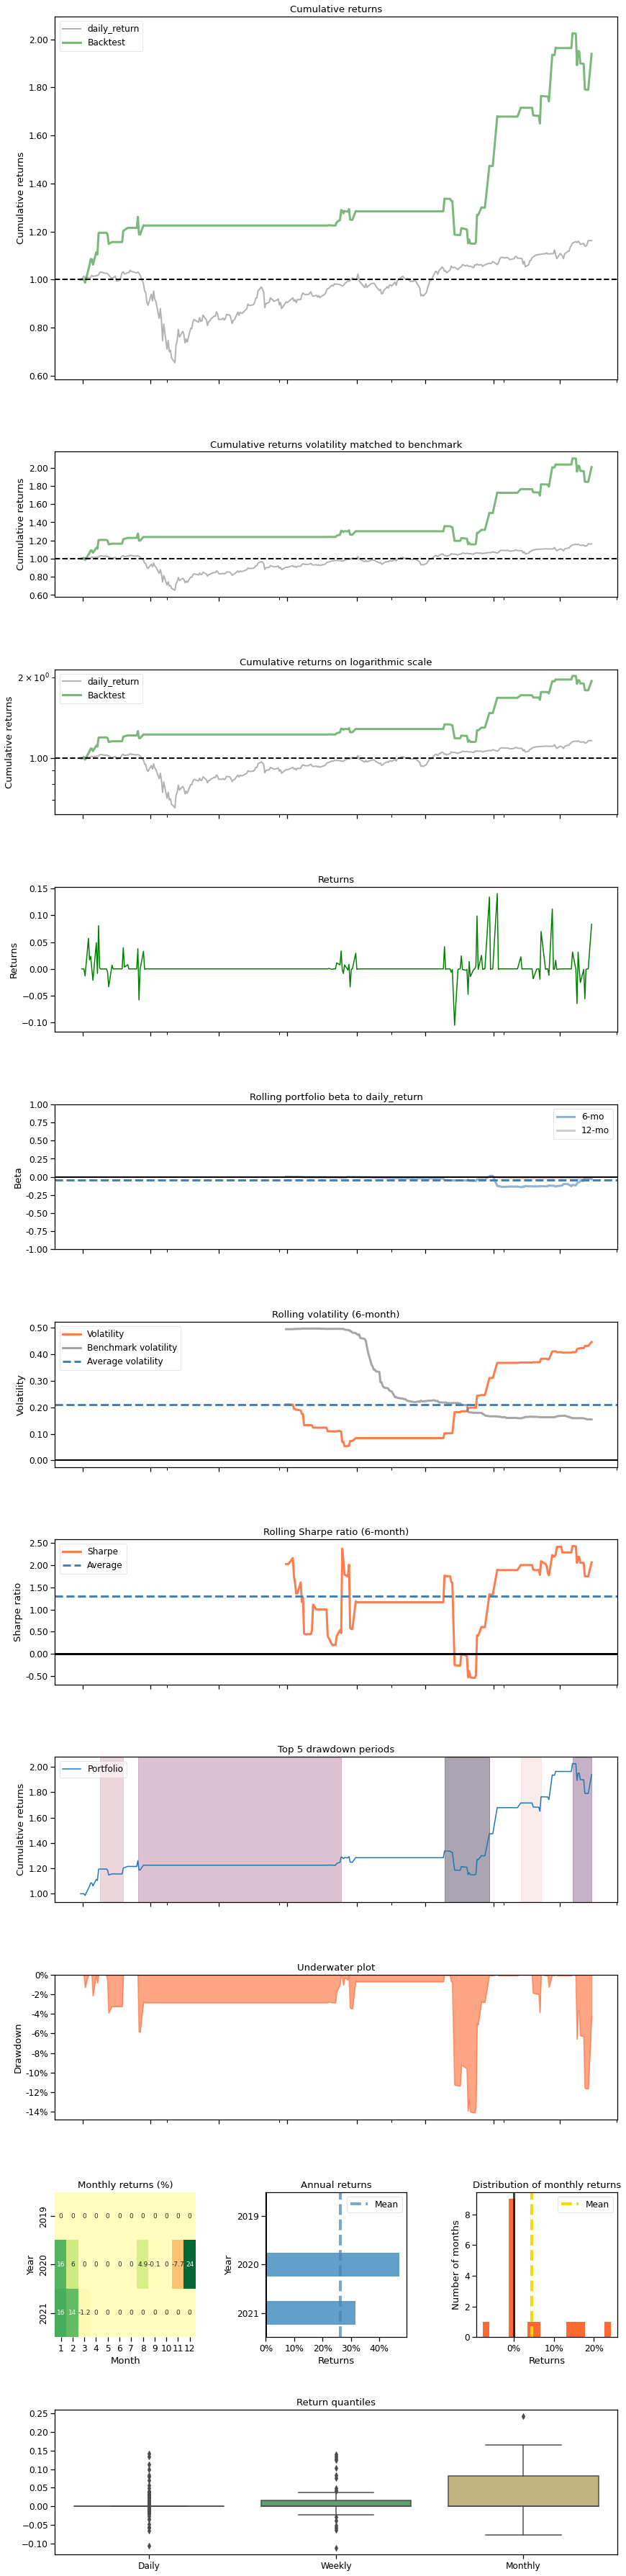

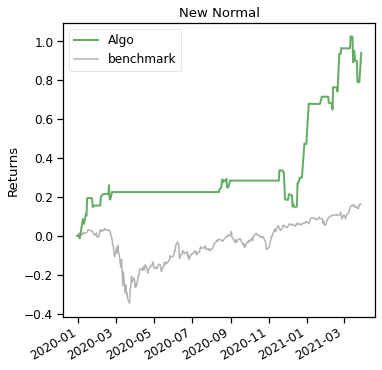

In [68]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])